# Evaluate PseudoSpectralNet

This notebook is a template to evaluate trained models. In order to do we need to load the data and the model first! 

In [1]:
pwd()

"/p/tmp/maxgelbr/code/nqg3-final/NeuralQG3.jl/scripts"

In [2]:
using Pkg
Pkg.activate(".") # assure it's the `scripts` env
    
using QG3, Plots, NeuralQG3, JLD2, NNlib, LuxCUDA, NeuralDELux, ComponentArrays, SlurmHyperopt, BenchmarkTools, OrdinaryDiffEq, ParameterSchedulers, Optimisers, Random, SciMLSensitivity, Lux, Zygote, Statistics, CUDA, NODEData, Printf, EllipsisNotation

const GPU = CUDA.functional()
const DEV = NeuralQG3.DetermineDevice(gpu=GPU)

COMPUTE_DATA = true
DATA_MODEL = :era # or :speedy 
NAME = "psn-era-newhpc"
SAVE_DIR = "../results/era/"

other_hyperpars = NeuralQG3.training_hyperpars()
(; N_batch, DT_FAC) = other_hyperpars

(; SAVE_NAME, SAVE_NAME_MODEL, SAVE_NAME_RESULTS, SAVE_NAME_SOL) = NeuralQG3.setup_savenames(; save_dir=SAVE_DIR, default_name=NAME)

@load SAVE_NAME_MODEL psn_hyperpars
println("Eval model with hyperpars:")
println(psn_hyperpars.pars)

S, qg3ppars, ψ_0, q_0 = load_data("T42", GPU=GPU)
qg3p = CUDA.@allowscalar QG3Model(qg3ppars; N_batch=1)
T = eltype(qg3p)
DT = T((2π/144)*DT_FAC) # in MM code: 1/144 * 2π

println(qg3p)

(t, q) = NeuralQG3.get_data(DATA_MODEL, qg3p, COMPUTE_DATA; S=S, DT=DT, q_0=q_0, t_save_length=nothing)
DT = DATA_MODEL == :era ? T(t[2]-t[1]) : DT

q = GPU ? T.(QG3.reorder_SH_gpu(q, qg3ppars)) : T.(q)
train, valid, test = CUDA.@allowscalar NODEData.NODEDataloader(reshape(q,size(q,1),size(q,2),size(q,3),1,size(q,4)), t, 2, valid_set=0.1, test_set=0.1)


  Activating project at `/p/tmp/maxgelbr/code/nqg3-final/NeuralQG3.jl/scripts`


using data / saving data as ../results/era/psn-era-newhpc-model-pars.jld2
Eval model with hyperpars:
(N_layers = 3, N_Nodes = 30, N_channels = 3, unet_kwargs = (kernel = (3, 3), N_channels = [24, 48, 96, 96], downconv = NeuralQG3.LongLatConvBlock, upconv = NeuralQG3.LongLatConvBlock), activation = NNlib.swish, additional_knowledge = true, conv_mode = :unet, znorm = true)
Pre-computed QG3Model{Float32} with  QG3ModelParameters{Float32} with N_lats=64 N_lons=128 L_max=42 on a Gaussian Grid on GPUwith gridsize (64, 130) and L_max42 on GPU
Loading ERA Data


(NODEData{CuArray{Float32, 5, CUDA.DeviceMemory},Int64} with 7007 batches with length 2, NODEData{CuArray{Float32, 5, CUDA.DeviceMemory},Int64} with 875 batches with length 2, NODEData{CuArray{Float32, 5, CUDA.DeviceMemory},Int64} with 875 batches with length 2)

No, lets set up the models, and make an initial forecast to check everything is right

In [3]:
#neural_de, ps, st = load_psn_ad(qg3p, psn_hyperpars, DT, N_batch; SAVE_NAME=SAVE_NAME, device=DEV)
S = psn_hyperpars.pars[:additional_knowledge] ? S : nothing
neural_de_sciml, ps, st = NeuralQG3.load_psn_sciml(qg3p, psn_hyperpars, DT; SAVE_NAME=SAVE_NAME, device=DEV, S=S, dtmax=DT)
test_trajectory = NODEData.get_trajectory(test, 300)
grid_forecast = NeuralQG3.GridForecast(test_trajectory, qg3p.g.SHtoG,input_SH=true, output_SH=true, data_SH=true, trajectory_call=false)
gf = grid_forecast(neural_de_sciml, ps, st)

(forecast_delta = Float32[0.0, 0.023613883, 0.042734504, 0.060895618, 0.077186, 0.09190325, 0.10321408, 0.1123905, 0.11955546, 0.12492913  …  0.25401488, 0.25643748, 0.2586348, 0.2602959, 0.26185623, 0.2637996, 0.27176398, 0.2758448, 0.27955604, 0.28271994],)

In [4]:
#neural_de, ps, st = load_psn_ad(qg3p, psn_hyperpars, DT, N_batch; SAVE_NAME=SAVE_NAME, device=DEV)
S = psn_hyperpars.pars[:additional_knowledge] ? S : nothing
neural_de_sciml, ps, st = NeuralQG3.load_psn_sciml(qg3p, psn_hyperpars, DT; SAVE_NAME=SAVE_NAME, device=DEV, S=S, dtmax=DT)
test_trajectory = NODEData.get_trajectory(test, 300)
grid_forecast = NeuralQG3.GridForecast(test_trajectory, qg3p.g.SHtoG,input_SH=true, output_SH=true, data_SH=true, trajectory_call=false)
gf = grid_forecast(neural_de_sciml, ps, st)

(forecast_delta = Float32[0.0, 0.023613857, 0.0427355, 0.0608976, 0.077188306, 0.091904886, 0.103214055, 0.11239353, 0.11955829, 0.12493203  …  0.2538773, 0.25622672, 0.25847632, 0.26018775, 0.26178512, 0.26381892, 0.27184206, 0.27592435, 0.2796213, 0.2827896],)

## Load Baselines

... and make forecasts with all models to compare them

In [4]:
ground_truth_grid = QG3.transform_grid_data(test_trajectory[2][..,1,:], qg3p)
 
forecast_model_q,st = neural_de_sciml(test_trajectory, ps, st)
forecast_model = QG3.transform_grid_data(forecast_model_q[..,1,:], qg3p);

In [5]:
# baselines 
baseline_J = NeuralQG3.JBaseline(qg3p);
forecast_J, __ = baseline_J((test_trajectory[1],test_trajectory[2][..,1,:]), nothing, NamedTuple())
forecast_J_grid = QG3.transform_grid_data(forecast_J, qg3p);

In [6]:
baseline_QG3 = NeuralQG3.QG3Baseline(qg3p);
forecast_QG3, __ = baseline_QG3((test_trajectory[1],test_trajectory[2][..,1,:]), nothing, NamedTuple())
forecast_QG3_grid = QG3.transform_grid_data(forecast_QG3, qg3p);

In [7]:
# climatology baseline, just repeat the climatology as a baseline
q_clim = mean(q, dims=4)

struct ClimatologyBaseline{T} 
    climatology::T
end 

(clim::ClimatologyBaseline)(X, ps, st) = repeat(clim.climatology,1,1,1,size(X[1],1)), st

baseline_clim = ClimatologyBaseline(q_clim)
forecast_clim, __ = baseline_clim((test_trajectory[1], test_trajectory[2][..,1,:]), nothing, NamedTuple());
forecast_clim_grid = QG3.transform_grid_data(forecast_clim, qg3p);

In [8]:
# this is directly grid based
save_name_baseline_unet_rnn = "unet-rnn-long-baseline"
#save_name_baseline_unet_rnn = "unet-rnn-short-baseline"

save_name_baseline_unet_rnn = "unet-rnn-era-newhpc"

baseline_unet_rnn, ps_rnn, st_rnn = NeuralQG3.load_rnn_unet(save_name_baseline_unet_rnn; save_dir=SAVE_DIR, dev=DEV)
forecast_unet_rnn_grid, st_rnn = NeuralDELux.trajectory(baseline_unet_rnn, (test_trajectory[1], reshape(ground_truth_grid, size(ground_truth_grid)[1:3]..., 1, size(ground_truth_grid,4))), ps_rnn, st_rnn);
forecast_unet_rnn_grid = forecast_unet_rnn_grid[..,1,:];

using data / saving data as ../results/era/unet-rnn-era-newhpc-model-pars.jld2


In [9]:
save_name_baseline_unet_node = "unet-baseline-sh-era"

names_unet = NeuralQG3.setup_savenames(; save_dir=SAVE_DIR, default_name=save_name_baseline_unet_node)
SAVE_NAME_UNET = names_unet[:SAVE_NAME]
SAVE_NAME_MODEL_UNET = names_unet[:SAVE_NAME_MODEL]
unet_hyperpars = load_object(SAVE_NAME_MODEL_UNET)

baseline_unet_node, ps_unetnode, st_unetnode = NeuralQG3.load_psn_sciml(qg3p, unet_hyperpars, DT; SAVE_NAME=SAVE_NAME_UNET, device=DEV, process_based=false, S=nothing, dtmax=DT)
forecast_unet_node, st_unetnode = baseline_unet_node(test_trajectory, ps_unetnode, st_unetnode)

forecast_unet_node_grid = QG3.transform_grid_data(forecast_unet_node[:,:,:,1,:], qg3p);


using data / saving data as ../results/era/unet-baseline-sh-era-model-pars.jld2


now compare the forecast with the $\delta$ metric

In [10]:
δ_long_psn = NeuralQG3.forecast_δ(forecast_model, ground_truth_grid, "norm")[:]
δ_long_J = NeuralQG3.forecast_δ(forecast_J_grid, ground_truth_grid, "norm")[:]
δ_long_QG3 =  NeuralQG3.forecast_δ(forecast_QG3_grid, ground_truth_grid, "norm")[:]
δ_long_RNN =  NeuralQG3.forecast_δ(forecast_unet_rnn_grid, ground_truth_grid, "norm")[:]
δ_long_UNET =  NeuralQG3.forecast_δ(forecast_unet_node_grid, ground_truth_grid, "norm")[:];

and plot those

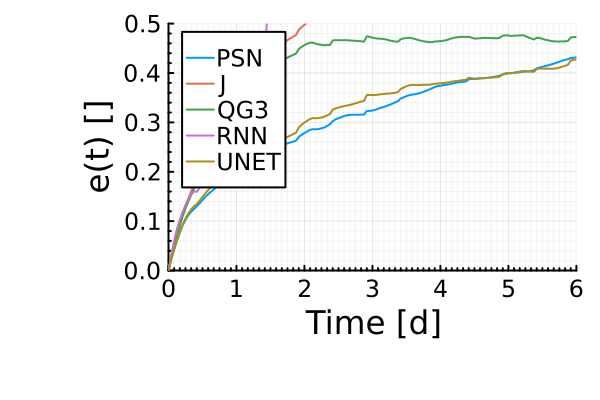

In [11]:
dtSI = (DT*qg3p.p.time_unit)
t_axis = 0:dtSI:dtSI*(length(δ_long_psn)-1)
plot(t_axis, Array(δ_long_psn), label="PSN")
plot!(t_axis, Array(δ_long_J), label="J")
plot!(t_axis, Array(δ_long_QG3), label="QG3")
plot!(t_axis, Array(δ_long_RNN), label="RNN")
plot!(t_axis, Array(δ_long_UNET), label="UNET", minorgrid=true, xminorticks=12, grid=:all, thickness_scaling = 2,xlabel="Time [d]", ylabel="e(t) []", fontsize=20,xlims=[0,6],ylims=[0,0.5])

Look at the average forecast delta instead!

In [11]:
# modify length of forecast here
dtSI = (DT*qg3p.p.time_unit)
N_forecast = 250
t_axis = 0:dtSI:dtSI*(N_forecast-1)
test_2 = (test_trajectory[1],test_trajectory[2][..,1,:])

grid_forecast_avg_delta = NeuralQG3.GridForecast(test_trajectory, qg3p.g.SHtoG, input_SH=true, output_SH=true, data_SH=true, modes=("average_forecast_delta"), N_avg=20, N_forecast=N_forecast, trajectory_call=false)
grid_forecast_avg_delta_no_batch = NeuralQG3.GridForecast(test_2, qg3p.g.SHtoG, input_SH=true, output_SH=true, data_SH=true, modes=("average_forecast_delta"), N_avg=20, trajectory_call=false, N_forecast=N_forecast)
grid_forecast_avg_delta_rnn = NeuralQG3.GridForecast(test_trajectory, qg3p.g.SHtoG, input_SH=false, output_SH=false, data_SH=true, modes=("average_forecast_delta"), N_avg=20, trajectory_call=true, N_forecast=N_forecast);

In [12]:
grid_forecast_avg_delta_clim = NeuralQG3.GridForecast(test_2, qg3p.g.SHtoG, input_SH=true, output_SH=true, data_SH=true, modes=("average_forecast_delta"), N_avg=100, trajectory_call=false, N_forecast=200);

In [13]:
δ_avg_psn=grid_forecast_avg_delta(neural_de_sciml, ps, st)[:average_forecast_delta]; # works

In [14]:
δ_avg_UNET=grid_forecast_avg_delta(baseline_unet_node, ps_unetnode, st_unetnode)[:average_forecast_delta]; # works

In [15]:
δ_avg_QG3=grid_forecast_avg_delta_no_batch(baseline_QG3, nothing, NamedTuple())[:average_forecast_delta] # works
δ_avg_J=grid_forecast_avg_delta_no_batch(baseline_J, nothing, NamedTuple())[:average_forecast_delta]; # works

In [ ]:
δ_avg_RNN=grid_forecast_avg_delta_rnn(baseline_unet_rnn, ps_rnn, st_rnn)[:average_forecast_delta]; # works

In [ ]:
δ_avg_clim=grid_forecast_avg_delta_clim(baseline_clim, nothing, NamedTuple())[:average_forecast_delta]; # works

Plot it in the same way as above

In [ ]:
fig = plot()
YLIMS = DATA_MODEL == :qg3 ? [0, 0.15] : [0, 0.5]
t_axis_plot2 = t_axis[1:length(Array(δ_avg_psn))]
plot!(fig, t_axis_plot2, Array(δ_avg_psn), label="PSN")
plot!(fig, t_axis_plot2, Array(δ_avg_J), label="J")
plot!(fig, t_axis_plot2[1:length(Array(δ_avg_clim))], Array(δ_avg_clim), label="Clim")

plot!(fig, t_axis_plot2, Array(δ_avg_QG3), label="QG3")
plot!(fig, t_axis_plot2, Array(δ_avg_RNN), label="Grid UNET")
plot!(fig, t_axis_plot2, Array(δ_avg_UNET), label="PS UNET", ylim=YLIMS, xlim=[0,4], minorgrid=true, xminorticks=12, grid=:all, thickness_scaling = 2,xlabel="Time [d]", ylabel="e(t) []", fontsize=20)

savefig(fig, string(SAVE_DIR,"delta-",NAME,".pdf"))
fig 

Save those for later comparison: 

In [73]:
save_δ_avg_models = string("delta-avg-",NAME,".jld2")
δ_avg_psn_short = δ_avg_psn
@save save_δ_avg_models δ_avg_psn_short

## Trajectory Animations

and plot the short term forecasts and compare them.

In [9]:
plot_field = (test_trajectory[1], Array(QG3.transform_grid_data(qprimetoψ(qg3p, forecast_model_q[..,1,:]), qg3p))[1,:,:,:])
anim, clims = NeuralQG3.animation(plot_field, title="PSN", return_clims=true)
gif(anim, string("model-anim-",NAME,".gif"), fps=30)

[ Info: Saved animation to /p/tmp/maxgelbr/code/neuralqg3-lux/neuralqg3/scripts/model-anim-psn-era.gif
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
plot_field = (test_trajectory[1], Array(QG3.transform_grid_data(qprimetoψ(qg3p,valid_trajectory[2]), qg3p))[1,:,:,:])
anim = NeuralQG3.animation(plot_field, title="Truth", clims=clims)
gif(anim, string("truth-anim-",NAME,".gif"), fps=30)

In [ ]:
plot_field = (test_trajectory[1], Array(QG3.transform_grid_data(qprimetoψ(qg3p, forecast_model_q - forecast_ground_truth_q), qg3p))[1,:,:,:])
anim = NeuralQG3.animation(plot_field, title="Diff", clims=clims)
gif(anim,gif(anim, string("model-diff-anim-",NAME,".gif"), fps=30), fps = 30)

# Snapshot Plots

In [24]:
#indices=2 .*[14,28,42,55]
indices=[6,12,18,24]
diff_field = Array(forecast_model - ground_truth_grid)[1,end:-1:1,:,:]
model_field = Array(forecast_model)[1,end:-1:1,:,:]
clims =  (-1.1*maximum(abs.(model_field)),1.1*maximum(abs.(model_field))) # get colormap maxima
println(string("Plotting Snapshots at time steps [d] :",indices .* DT .* qg3p.p.time_unit))

Plotting Snapshots at time steps [d] :Float32[0.25, 0.5, 0.75, 1.0]


In [63]:
p1=heatmap(model_field[:,:,indices[1]],c=:balance,clims=clims, ylabel="Latitude", colorbar=nothing, yticks = nothing, xticks= nothing, title="1d")
p2=heatmap(model_field[:,:,indices[2]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="2d")
p3=heatmap(model_field[:,:,indices[3]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="3d")
p4=heatmap(model_field[:,:,indices[4]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="4d")

p5=heatmap(diff_field[:,:,indices[1]],c=:balance,clims=clims, ylabel="Latitude", colorbar=nothing, xlabel="Longitude", yticks = nothing, xticks= nothing)
p6=heatmap(diff_field[:,:,indices[2]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing)
p7=heatmap(diff_field[:,:,indices[3]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing)
p8=heatmap(diff_field[:,:,indices[4]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing)

plot(p1,p2,p3,p4,p5,p6,p7,p8, layout=(2,4), legend=false)
#savefig(string("snapshots-",NAME,".pdf"))

"/p/tmp/maxgelbr/code/neuralqg3-lux/neuralqg3/scripts/snapshots-psn-short.pdf"

In [25]:
lons = 1:128 
lats = 1:64
N_levels = 10
aspect = 1

p1=contourf(lons, lats, model_field[:,:,indices[1]],c=:balance,clims=clims, ylabel="Latitude", colorbar=nothing, levels=N_levels, yticks = nothing, xticks= nothing, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]], title="1d", aspect_ratio=aspect)
p2=contourf(model_field[:,:,indices[2]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="2d", levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])
p3=contourf(model_field[:,:,indices[3]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="3d", levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])
p4=contourf(model_field[:,:,indices[4]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xticks= nothing, title="4d", levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])

p5=contourf(diff_field[:,:,indices[1]],c=:balance,clims=clims, ylabel="Latitude", colorbar=nothing, xlabel="Longitude", yticks = nothing, xticks= nothing, levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])
p6=contourf(diff_field[:,:,indices[2]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing, levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])
p7=contourf(diff_field[:,:,indices[3]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing, levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])
p8=contourf(diff_field[:,:,indices[4]],c=:balance,clims=clims, yticks = nothing, colorbar=nothing, xlabel="Longitude", xticks= nothing, levels=N_levels, aspect_ratio=aspect, xlims=[lons[1],lons[end]], ylims=[lats[1],lats[end]])

plot(p1,p2,p3,p4,p5,p6,p7,p8, layout=(2,4), legend=false)
savefig(string(SAVE_DIR,"snapshots-contour",NAME,".pdf"))

"/p/tmp/maxgelbr/code/neuralqg3-lux/neuralqg3/results/era/snapshots-contourpsn-era.pdf"

## Error by Latitude 

analyse the error by latitude 

In [70]:
grid_forecast_latitude = NeuralQG3.GridForecast(test_trajectory, qg3p.g.SHtoG,input_SH=true, output_SH=true, data_SH=true, trajectory_call=false, modes=("latitude_delta"))

latitude_error = grid_forecast_latitude(neural_de_sciml, ps, st)

(latitude_delta = [0.0 0.0 … 0.0 0.0;;;;; 0.00048274835 0.0004844944 … 0.0002308788 0.00024125975;;;;; 0.0009694755 0.0009630874 … 0.00046432996 0.00047251408;;;;; … ;;;;; 0.015294931 0.0123601435 … 0.017869882 0.014342626;;;;; 0.015547688 0.01235939 … 0.01867129 0.015090517;;;;; 0.015812391 0.012362097 … 0.019455072 0.015822504],)

and plot that...

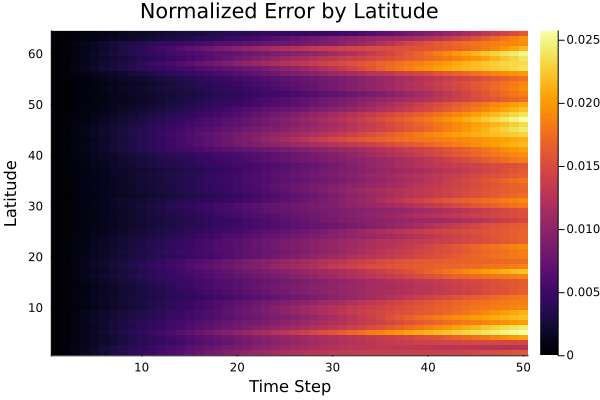

In [71]:
heatmap(latitude_error[:latitude_delta][1,:,1,1,:], xlabel="Time Step", ylabel="Latitude", title="Normalized Error by Latitude")
#savefig(string("latitude-error-",NAME,".pdf"))